In [ ]:
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
import catboost
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_filtered_with_ids = pd.read_pickle("/content/drive/MyDrive/Other/filtered_data1.pkl")

In [ ]:
cb_model = CatBoostClassifier(random_seed=42, eval_metric='AUC', subsample=1)

In [ ]:
data_filtered_with_ids["target"] = data_filtered_with_ids["conversions"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
data_filtered_with_ids["date_time"].min(), data_filtered_with_ids["date_time"].max()

('2016-09-02 01:00:00', '2016-09-16 04:00:00')

In [ ]:
cols_to_use = list(data_filtered_with_ids.columns)

In [ ]:
cols_to_use.remove("date_time")
cols_to_use.remove("conversions")
cols_to_use.remove("impressions") # норм ли это фича? По идее нет. Можно сделать киллерфичу со статистикой по предыдущим дням, но сейчас нам это не нужно


In [ ]:
train_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] < "2016-09-14", cols_to_use]
valid_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] > "2016-09-14", cols_to_use]

In [ ]:
categorical_cols = ["banner_id", "advertiser_id", "offer_id", "zone_id", "affiliate_id", "geo", "region_code", "city_code",
                    "os_type", "os", "os_version", "device_type", "device", "browser", "lang", "isp", "mobile_isp",
                    "proxy", "netspeed", "day_of_week", "hour"]
nums_cols = ["varp", "varcc", "varpp"]

In [ ]:
for colname in categorical_cols:
    train_df[colname] = train_df[colname].astype(str)
    valid_df[colname] = valid_df[colname].astype(str)

In [ ]:
train_df["target"].value_counts()

0    814493
1      1869
Name: target, dtype: int64

In [ ]:
valid_df["target"].value_counts()

0    126956
1       305
Name: target, dtype: int64

In [ ]:
train_cols = categorical_cols + nums_cols

In [ ]:
train_df["weight"] = train_df["CTR"].apply(lambda x: x if x > 0 else 1)
valid_df["weight"] = valid_df["CTR"].apply(lambda x: x if x > 0 else 1)

In [ ]:
valid_df["weight"].value_counts()

1.000000    127200
0.500000        26
0.333333        10
0.250000         7
0.200000         6
0.142857         2
0.061404         1
0.029703         1
0.034483         1
0.166667         1
0.020833         1
0.080000         1
0.040000         1
0.111111         1
0.013699         1
0.014085         1
Name: weight, dtype: int64

In [ ]:
train_pool = catboost.Pool(data=train_df[train_cols], label=train_df["target"],
                           cat_features=categorical_cols, weight=train_df["weight"] * 10)
valid_pool = catboost.Pool(data=valid_df[train_cols], label=valid_df["target"],
                           cat_features=categorical_cols, weight=valid_df["weight"] * 10)

In [ ]:
cb_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=50)

Learning rate set to 0.166014
0:	test: 0.5000000	best: 0.5000000 (0)	total: 952ms	remaining: 15m 51s
50:	test: 0.8069431	best: 0.8069431 (50)	total: 3m 33s	remaining: 1h 6m 4s
100:	test: 0.8131152	best: 0.8138856 (92)	total: 7m 17s	remaining: 1h 4m 50s
150:	test: 0.8122721	best: 0.8138856 (92)	total: 11m 27s	remaining: 1h 4m 27s
200:	test: 0.8119109	best: 0.8138856 (92)	total: 15m 42s	remaining: 1h 2m 28s
250:	test: 0.8111678	best: 0.8138856 (92)	total: 20m 15s	remaining: 1h 25s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8138856421
bestIteration = 92

Shrink model to first 93 iterations.


In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(valid_df[train_cols])

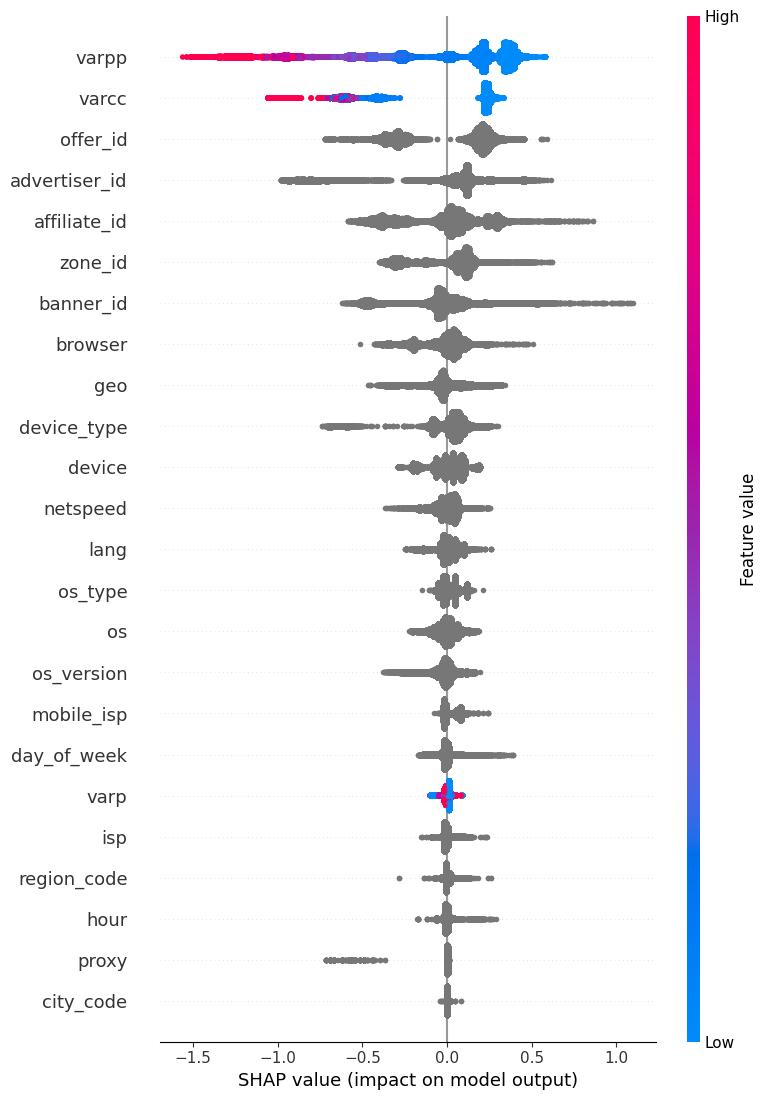

In [ ]:
shap.summary_plot(shap_values, valid_df[train_cols], max_display=len(train_cols))

In [ ]:
feature_importances = pd.DataFrame(cb_model.feature_importances_, index=cb_model.feature_names_, columns=["importance"])

In [ ]:
feature_importances.sort_values("importance", ascending=False)

,importance
varpp,19.658252
varcc,14.376737
advertiser_id,12.625550
affiliate_id,8.256966
offer_id,6.806050
zone_id,6.656936
geo,4.967285
banner_id,4.963193
device_type,4.622277
device,2.994712
